In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import time

In [2]:
# create data augmentation composer 
transformations = torchvision.transforms.Compose([
  torchvision.transforms.ColorJitter(.2, .1, .25, .25),
  torchvision.transforms.RandomCrop(32, padding = 2),
  torchvision.transforms.RandomHorizontalFlip(.25),
  torchvision.transforms.RandomAffine(2, translate= (1.,1.)),
  torchvision.transforms.RandomPerspective(.1,p=.25),
  torchvision.transforms.ToTensor(),
]) 



train_ds = torchvision.datasets.CIFAR100(".", train = True, transform = transforms.ToTensor(), download = True)
test_ds = torchvision.datasets.CIFAR100(".", train = False, transform = transforms.ToTensor(), download = True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


In [3]:
from torchsummary import summary
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.MaxPool2d(2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.MaxPool2d(2)
    )

    # output_shape: o = i + 2p - (k-1) - 1 + 1 = i + 2p -k + 1. 
    # k=3 => o = i + 2*1 - 3 + 1 = i (same convolution). So the only thing that effects to output shape is pooling(2) layer.
    # Therefore output should be 32x32 -> 16x16 -> 8x8 -> 4x4 (3 times pooling)
    self.fc = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(256 * 4 * 4, 1024),
        nn.Dropout(.25),
        nn.Linear(1024, K)
    )
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [4]:
# define a model
K = len(train_ds.classes)
cnn = CNN(K)
# pick a device and pass the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device is",device)
cnn.to(device)
# set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())

summary(cnn, (3, 32, 32))

Current device is cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,584
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        MaxPoo

In [5]:
# define predict and train functions
def train(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  train_accs = np.zeros(epochs)
  test_accs = np.zeros(epochs)

  for i in range(epochs):
    t0 = time.time()
    tr_loss = []
    te_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      tr_loss.append(loss.item())
      # backward propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()



    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      te_loss.append(loss.item())

    # predict both train and test sets
    _, tr_acc = predict(model, train_loader)
    _, te_acc = predict(model, test_loader)

    train_losses[i] = np.mean(tr_loss)
    test_losses[i] = np.mean(te_loss)
    test_accs[i] = te_acc
    train_accs[i] = tr_acc



    t1 = time.time()
    print("-"*50)
    print(f"Epochs {i+1}/{epochs} took {t1-t0:.3f}s")
    print(f"average loss for train batches: {np.mean(tr_loss):.4f}, train accuracy: {tr_acc:.4f}")
    print(f"average loss for test batches: {np.mean(te_loss):.4f}, test accuracy: {te_acc:.4f}")
    print("-"*50)

  return train_losses, test_losses, train_accs, test_accs

def predict(model, data_loader, calc_acc=True):
  n_total = 0
  n_correct = 0
  predictions = np.array([])
  with torch.no_grad():
    for features, targets in data_loader:
      features, targets = features.to(device), targets.to(device)
      outputs = model(features)
      _, preds = torch.max(outputs, 1)
      if calc_acc:
        n_correct += ((preds == targets).sum().item())
        n_total += (targets.shape[0])
      predictions = np.concatenate((predictions, preds.cpu().numpy()))

  return [predictions, (n_correct/n_total)] if calc_acc else predictions


In [6]:
n_epochs = 20
train_losses, test_losses, train_accs, test_accs = train(cnn, criterion, optimizer, train_loader, test_loader, n_epochs)

--------------------------------------------------
Epochs 1/20 took 20.004s
average loss for train batches: 4.1826, train accuracy: 0.2302
average loss for test batches: 3.3834, test accuracy: 0.2150
--------------------------------------------------
--------------------------------------------------
Epochs 2/20 took 19.605s
average loss for train batches: 2.9238, train accuracy: 0.3803
average loss for test batches: 2.6222, test accuracy: 0.3487
--------------------------------------------------
--------------------------------------------------
Epochs 3/20 took 19.508s
average loss for train batches: 2.4117, train accuracy: 0.4509
average loss for test batches: 2.3631, test accuracy: 0.3988
--------------------------------------------------
--------------------------------------------------
Epochs 4/20 took 19.544s
average loss for train batches: 2.1270, train accuracy: 0.5095
average loss for test batches: 2.1915, test accuracy: 0.4385
-----------------------------------------------

In [7]:
# plot the losses and accuracies
fig = go.Figure()
x = list(range(1,n_epochs+1))

fig.add_trace(go.Scatter(x=x, y=train_losses, mode = "lines+markers", name = 'train_loss'))
fig.add_trace(go.Scatter(x=x, y=test_losses, mode = "lines+markers", name = 'test_loss'))
fig.show()

fig.data = [] # clear the traces

fig.add_trace(go.Scatter(x=x, y=train_accs, mode = "lines+markers", name = 'train accuracy'))
fig.add_trace(go.Scatter(x=x, y=test_accs, mode = "lines+markers", name = 'test accuracy'))
fig.show()


In [8]:
# make predictions
preds = predict(cnn, test_loader, calc_acc=False)
test_y = test_ds.targets
test_x = test_ds.data
labels = test_ds.classes

ValueError: ignored

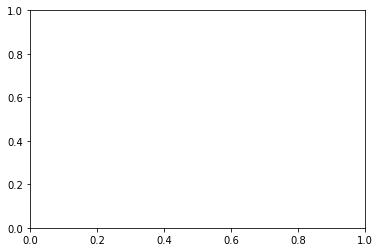

In [9]:
# get random misclassified images
misclassified_idx = np.where(preds != test_y)[0]
r = np.random.choice(misclassified_idx)
plt.plot(test_x[r].reshape(32,32,3), cmap = 'gray')
plt.title("Predicted: %s | True Label: %s" % ( labels[preds[r]], labels[test_y[r]] ))
plt.show()